In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

from pandas import read_csv
import numpy as np
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
df = pd.read_csv(
  "New_york.csv", 
  parse_dates=['timestamp'], 
  index_col="timestamp"
)

In [4]:
df.shape

(17356, 9)

In [5]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2017-01-01 00:00:00,16,0.24,0.2879,0.81,0.0,1,0,1,1
2017-01-01 01:00:00,40,0.22,0.2727,0.80,0.0,1,0,1,1
2017-01-01 02:00:00,32,0.22,0.2727,0.80,0.0,1,0,1,1
2017-01-01 03:00:00,13,0.24,0.2879,0.75,0.0,1,0,1,1
2017-01-01 04:00:00,1,0.24,0.2879,0.75,0.0,1,0,1,1


In [6]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

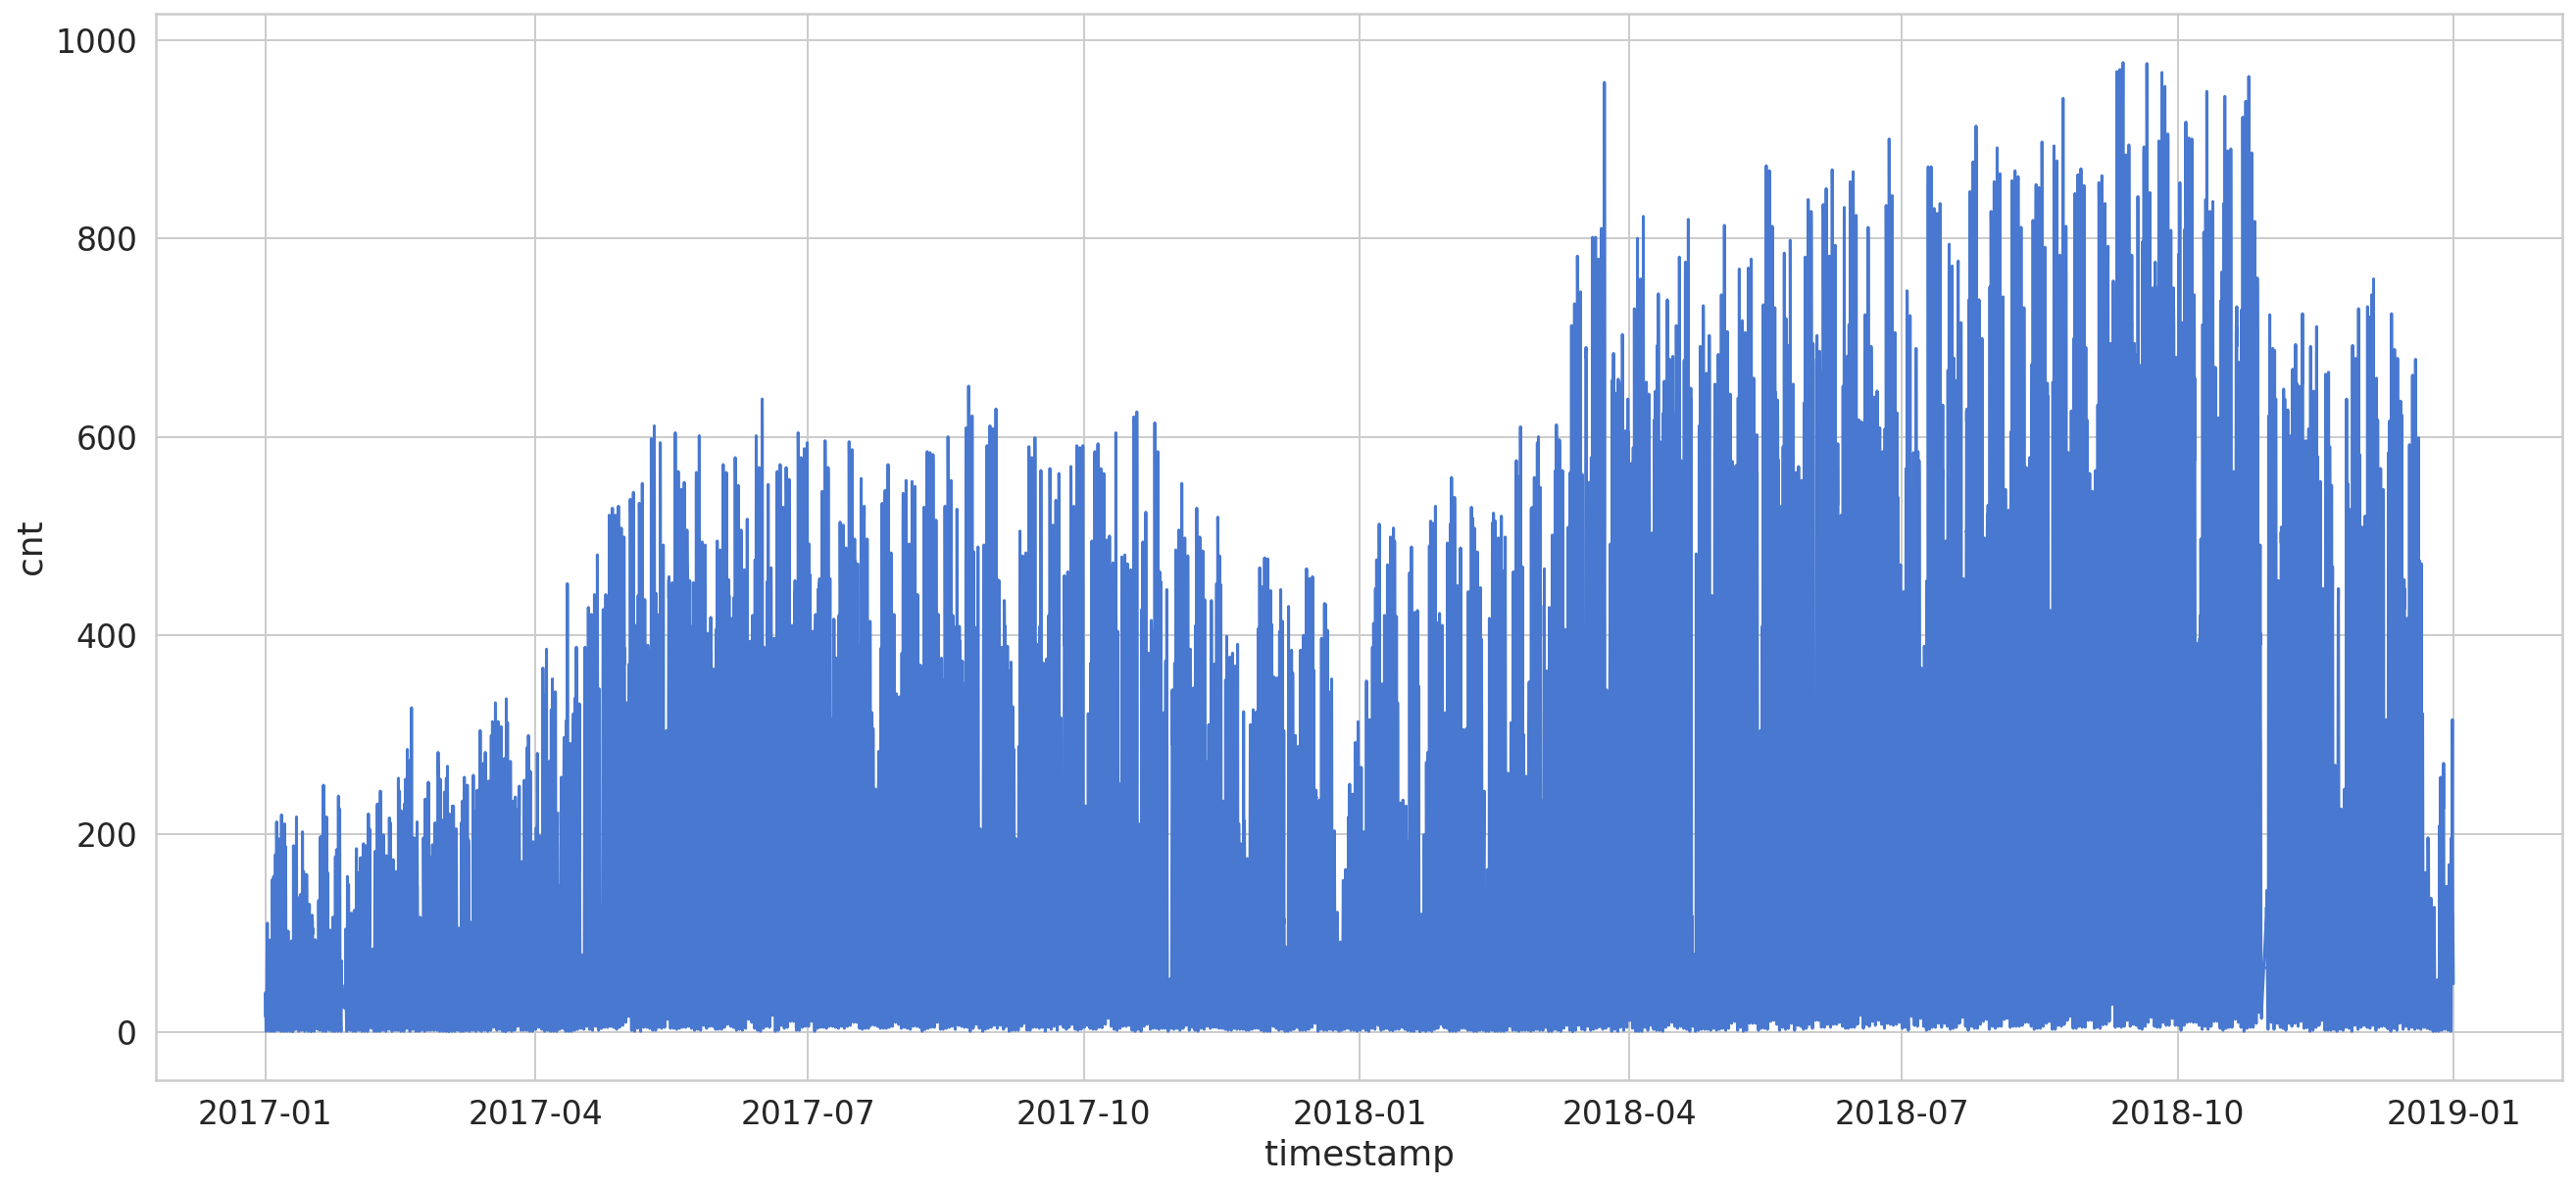

In [7]:
sns.lineplot(x=df.index, y="cnt", data=df);

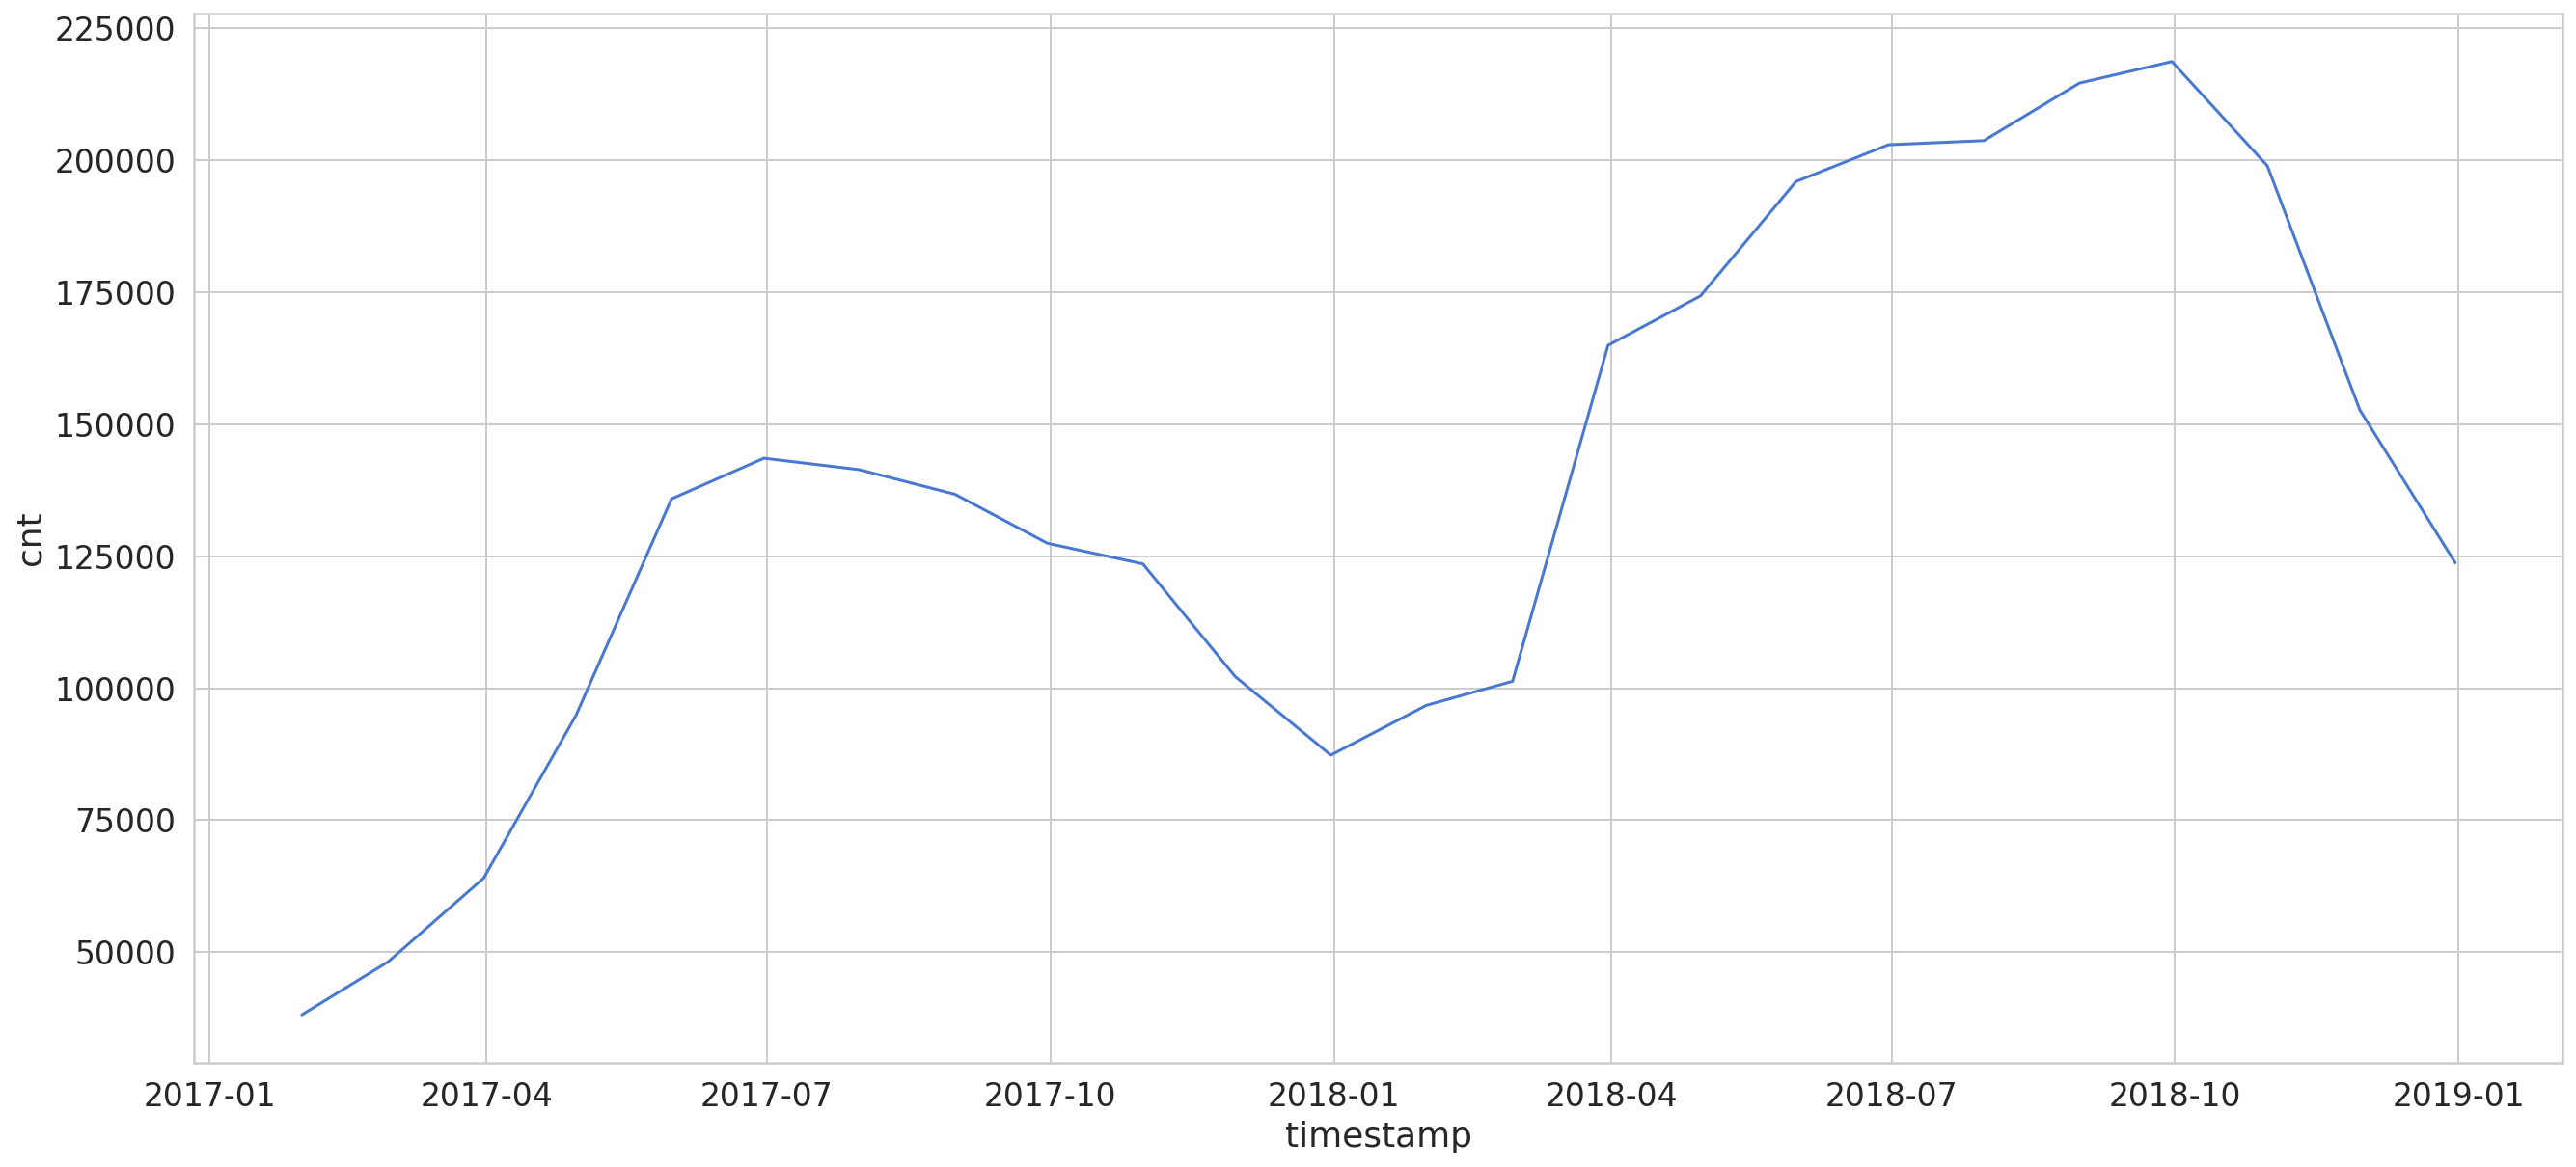

In [8]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="cnt", data=df_by_month);

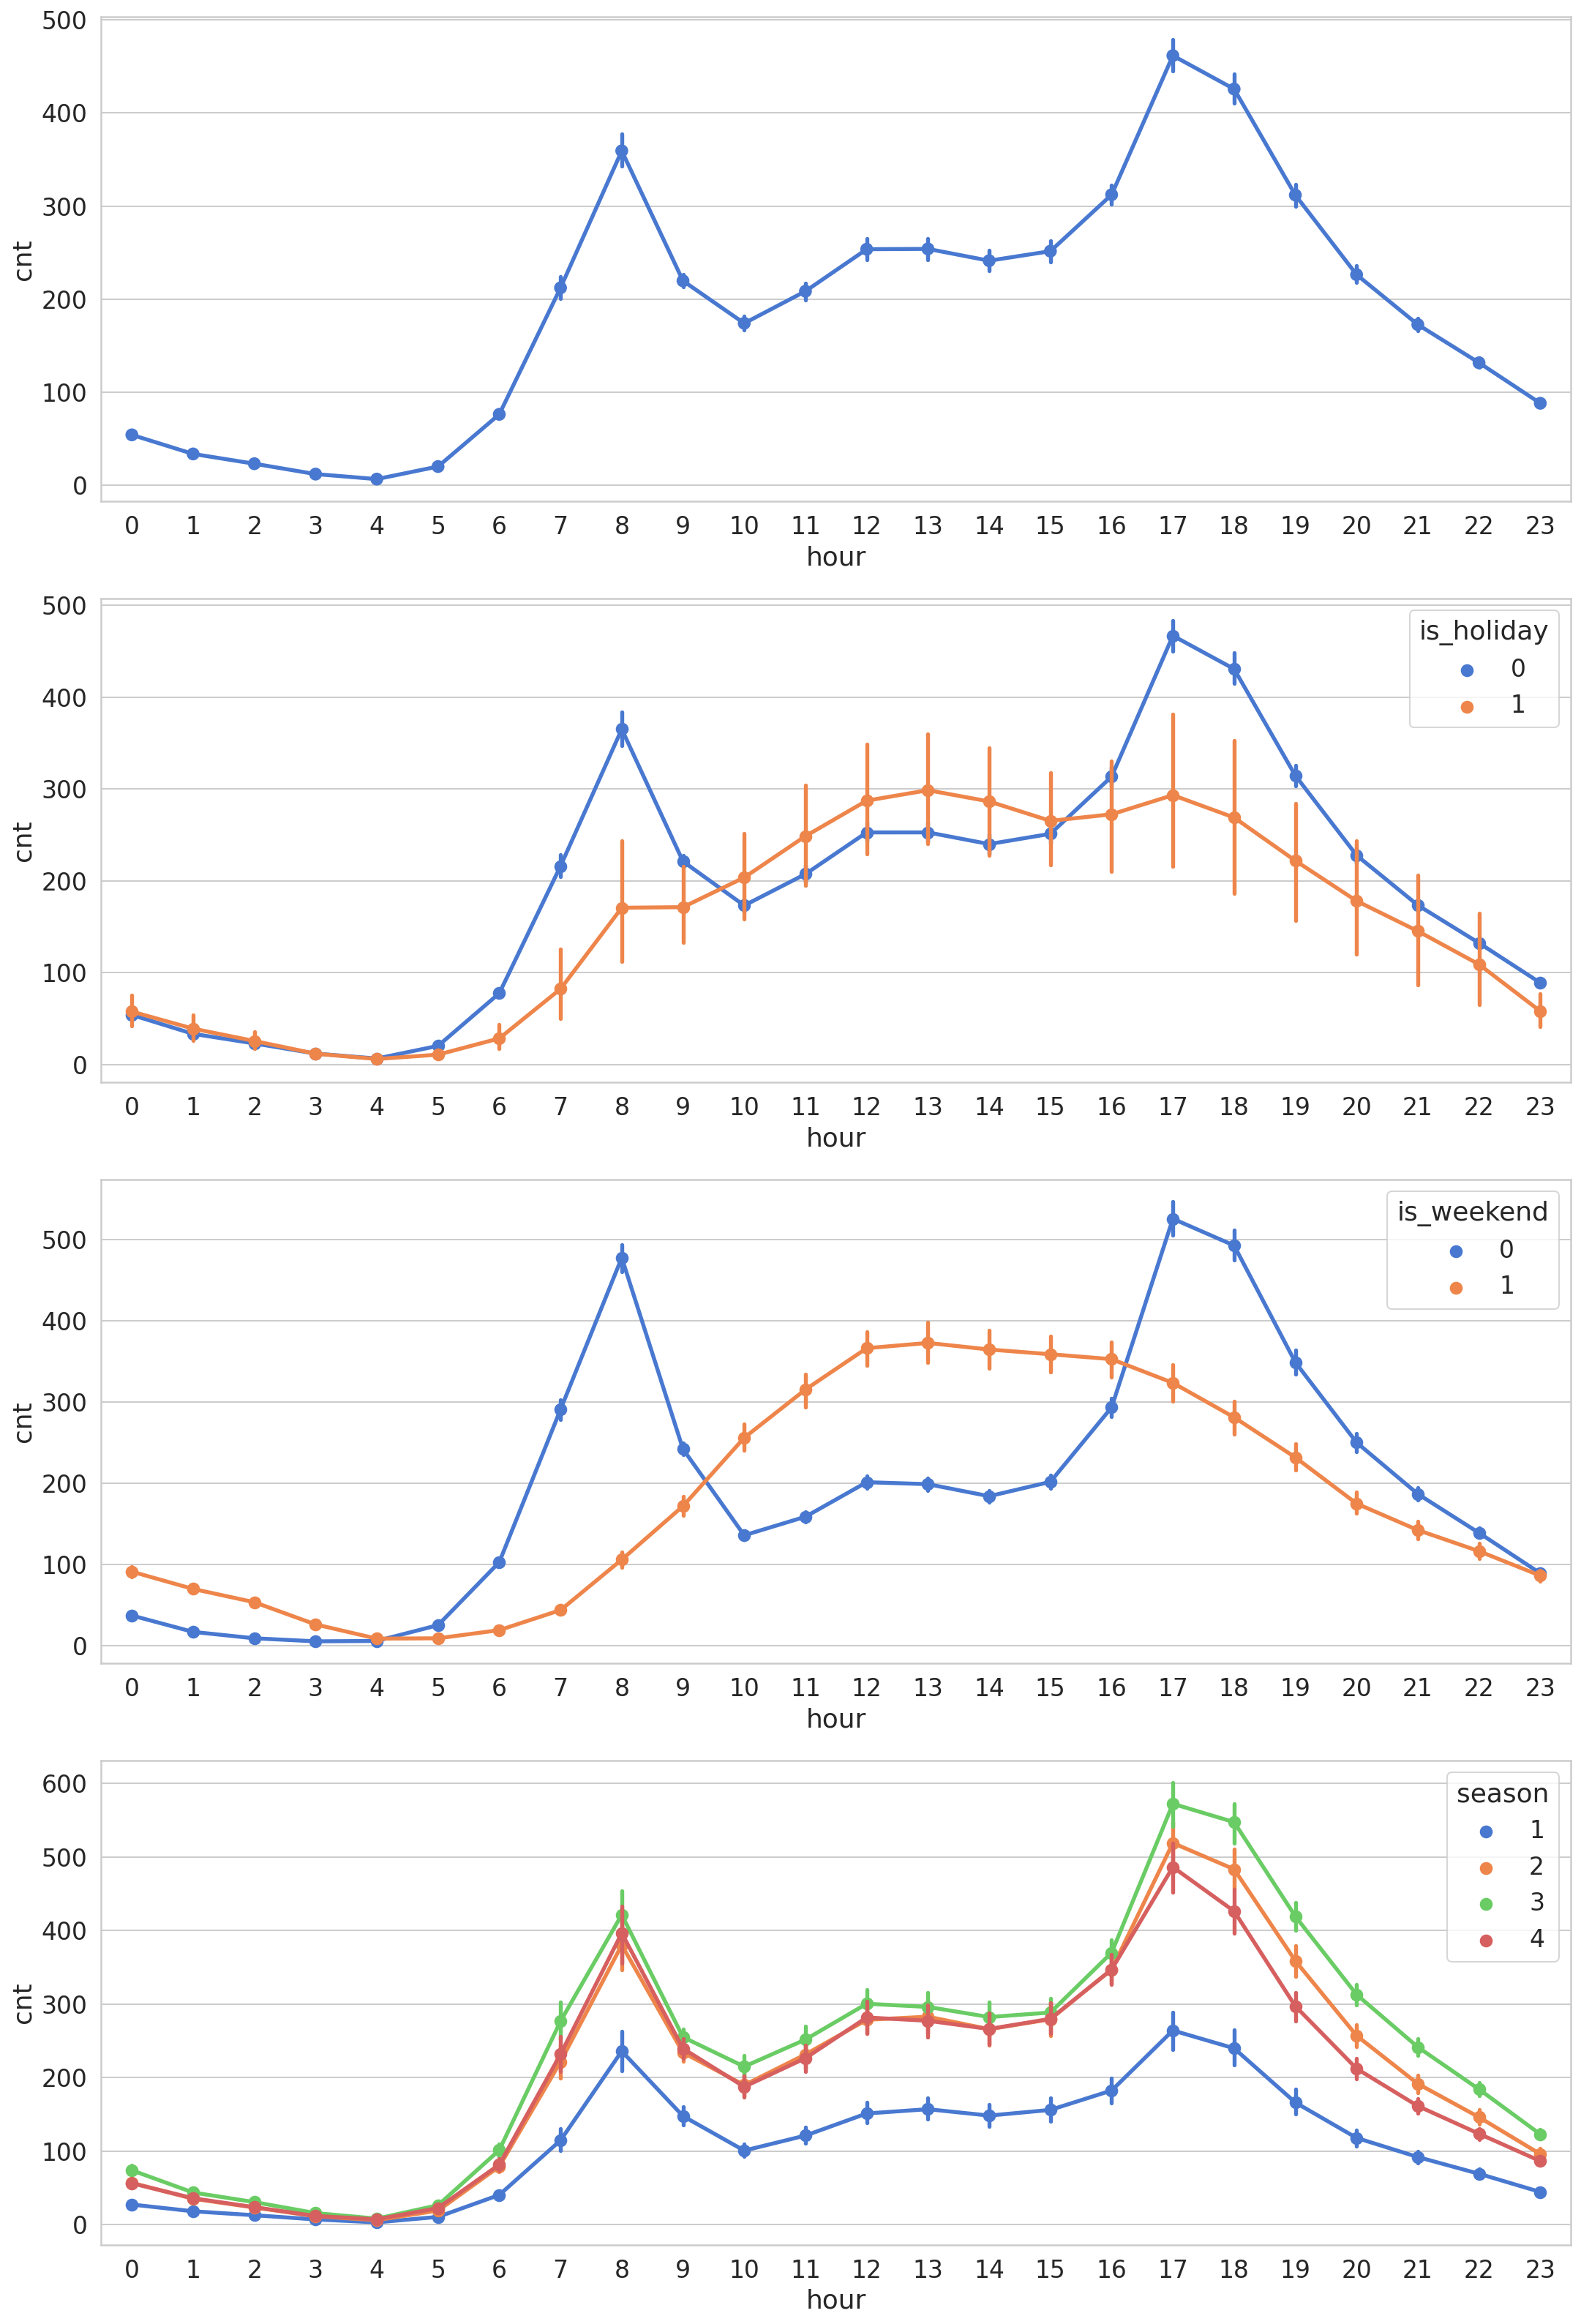

In [9]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='cnt', ax=ax1)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday', ax=ax2)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_weekend', ax=ax3)
sns.pointplot(data=df, x='hour', y='cnt', hue='season', ax=ax4);

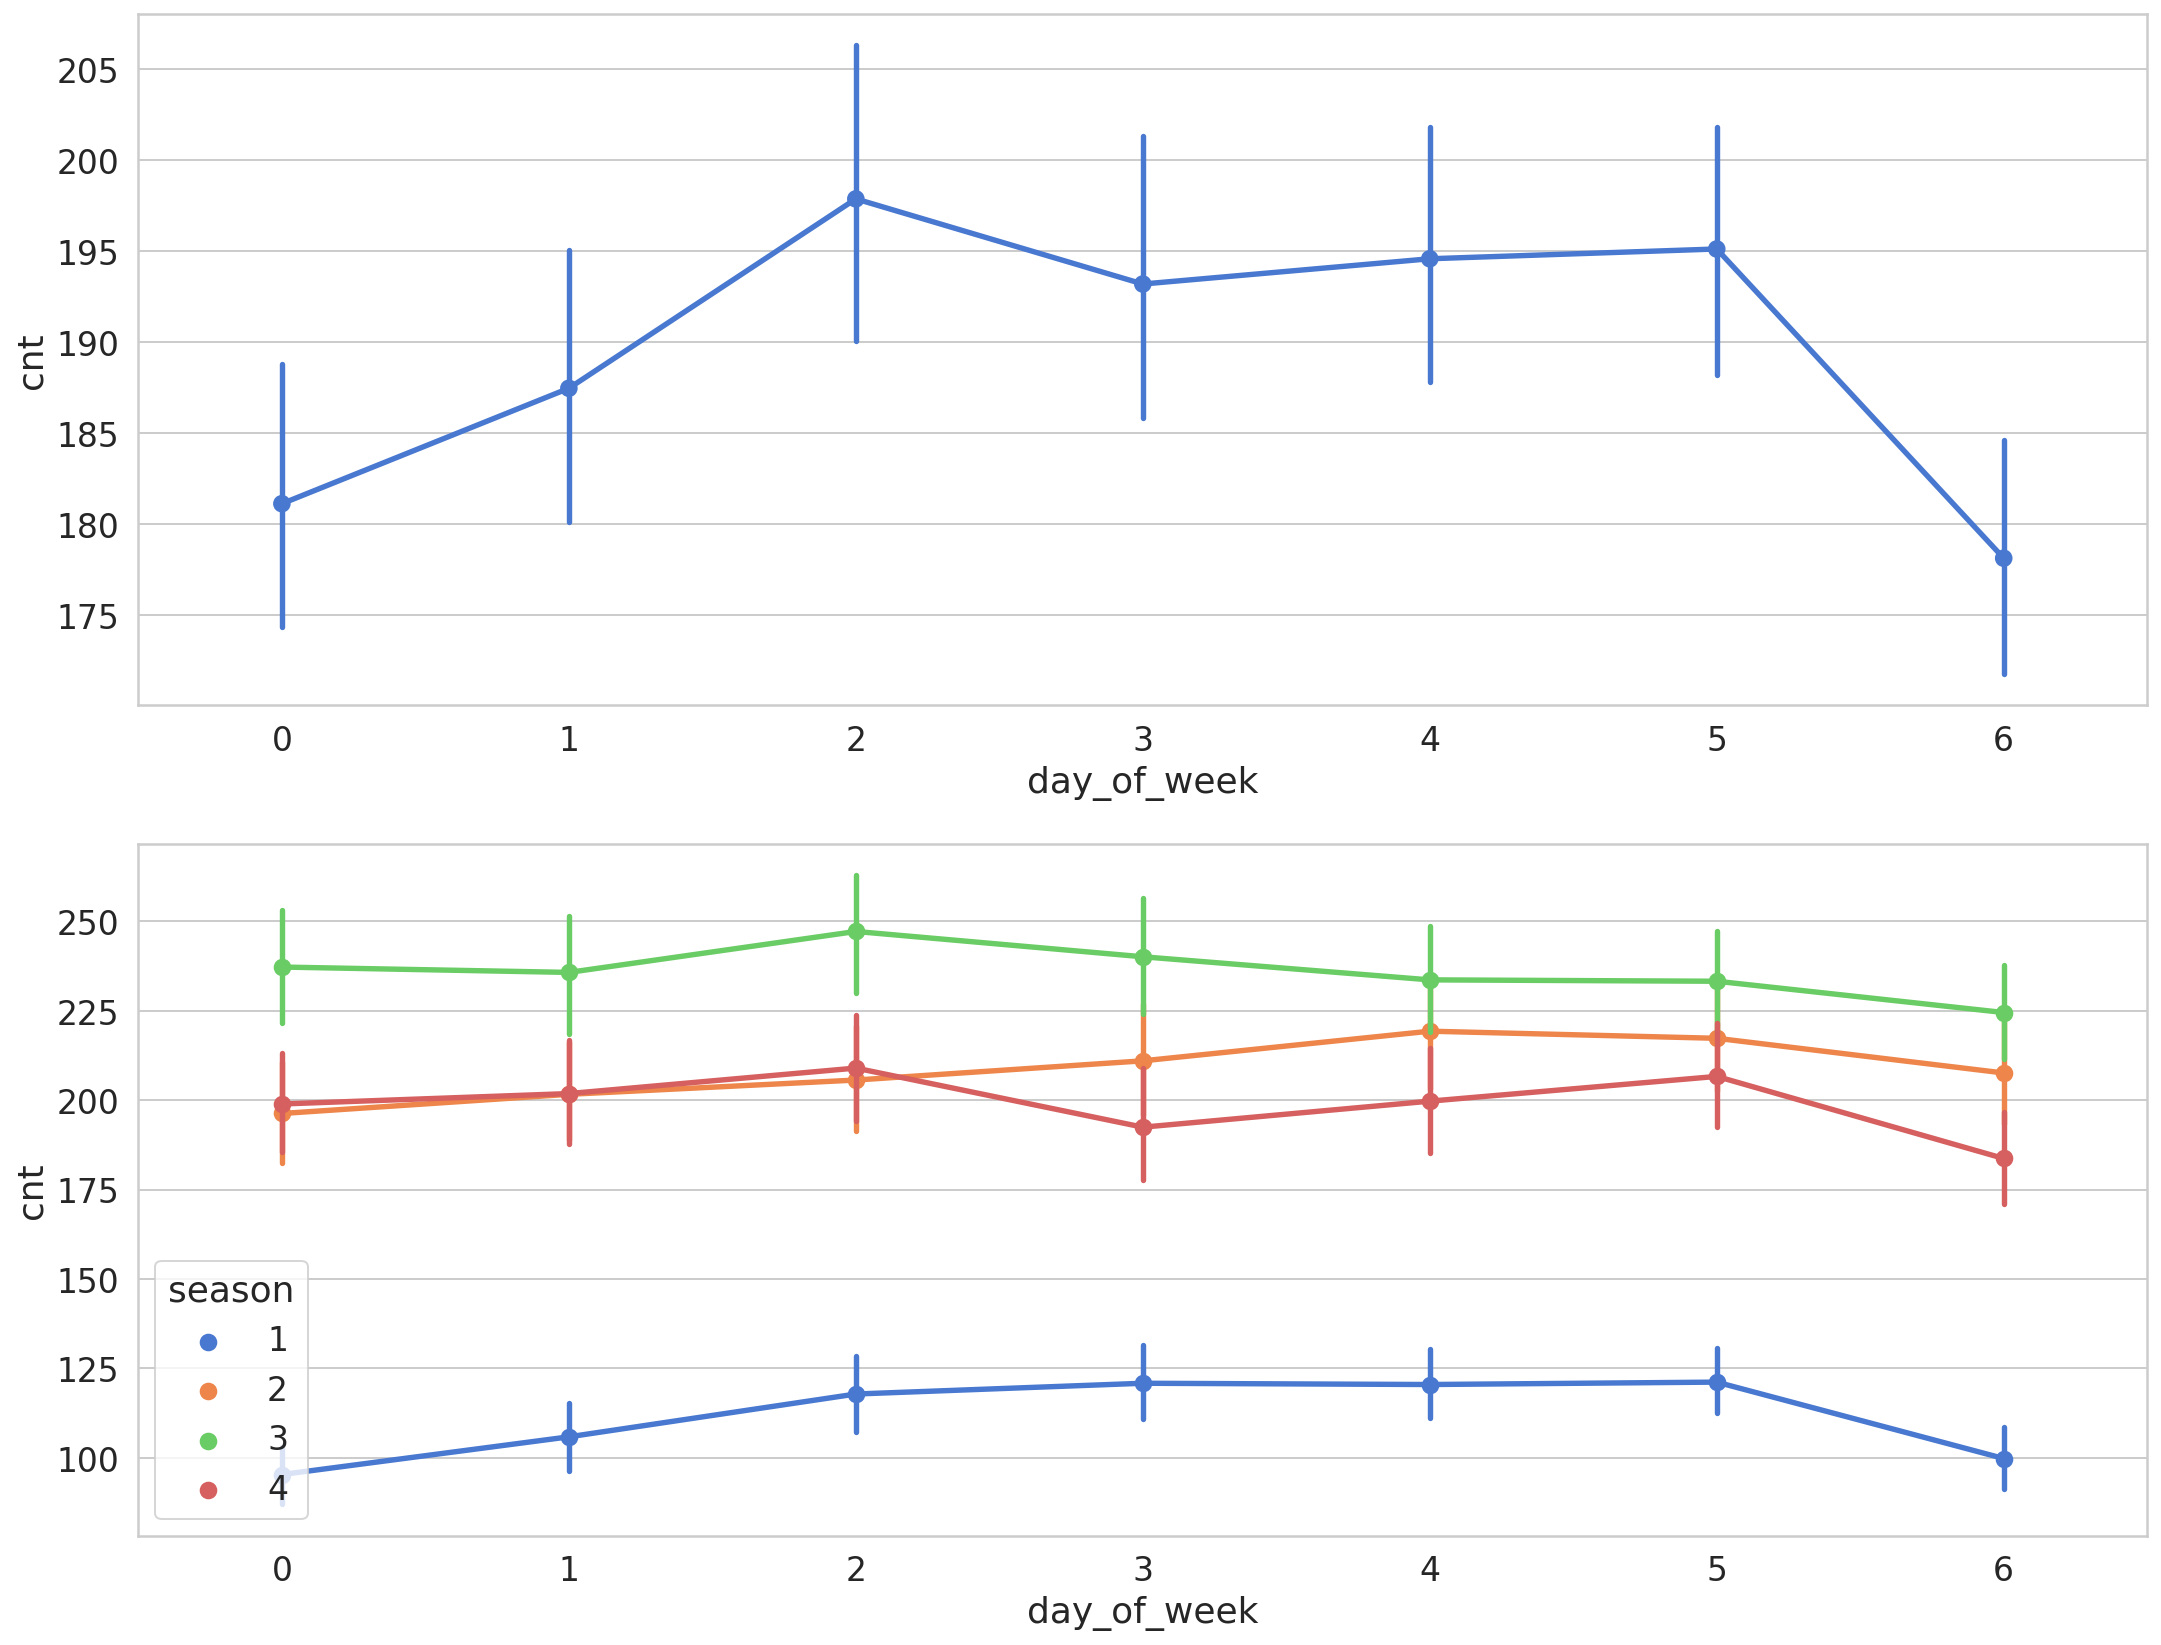

In [10]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df, x='day_of_week', y='cnt', ax=ax1)
sns.pointplot(data=df, x='day_of_week', y='cnt', hue='season', ax=ax2);

In [11]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

15620 1736


# Preprocessing

In [12]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-12-92b06493bae2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cnt'] = cnt_transformer.transform(train[['cnt']])
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [13]:

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [14]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15610, 10, 13) (15610,)


In [15]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [16]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
440/440 [==============================] - 19s 33ms/step - loss: 0.2729 - val_loss: 0.2313
Epoch 2/30
440/440 [==============================] - 14s 31ms/step - loss: 0.0839 - val_loss: 0.0899
Epoch 3/30
440/440 [==============================] - 14s 31ms/step - loss: 0.0593 - val_loss: 0.0985
Epoch 4/30
440/440 [==============================] - 14s 31ms/step - loss: 0.0436 - val_loss: 0.0895
Epoch 5/30
440/440 [==============================] - 17s 39ms/step - loss: 0.0403 - val_loss: 0.0676
Epoch 6/30
440/440 [==============================] - 16s 37ms/step - loss: 0.0367 - val_loss: 0.0621
Epoch 7/30
440/440 [==============================] - 13s 30ms/step - loss: 0.0344 - val_loss: 0.0551
Epoch 8/30
440/440 [==============================] - 14s 31ms/step - loss: 0.0336 - val_loss: 0.0544
Epoch 9/30
440/440 [==============================] - 13s 30ms/step - loss: 0.0311 - val_loss: 0.0578
Epoch 10/30
440/440 [==============================] - 13s 30ms/step - loss: 0.029

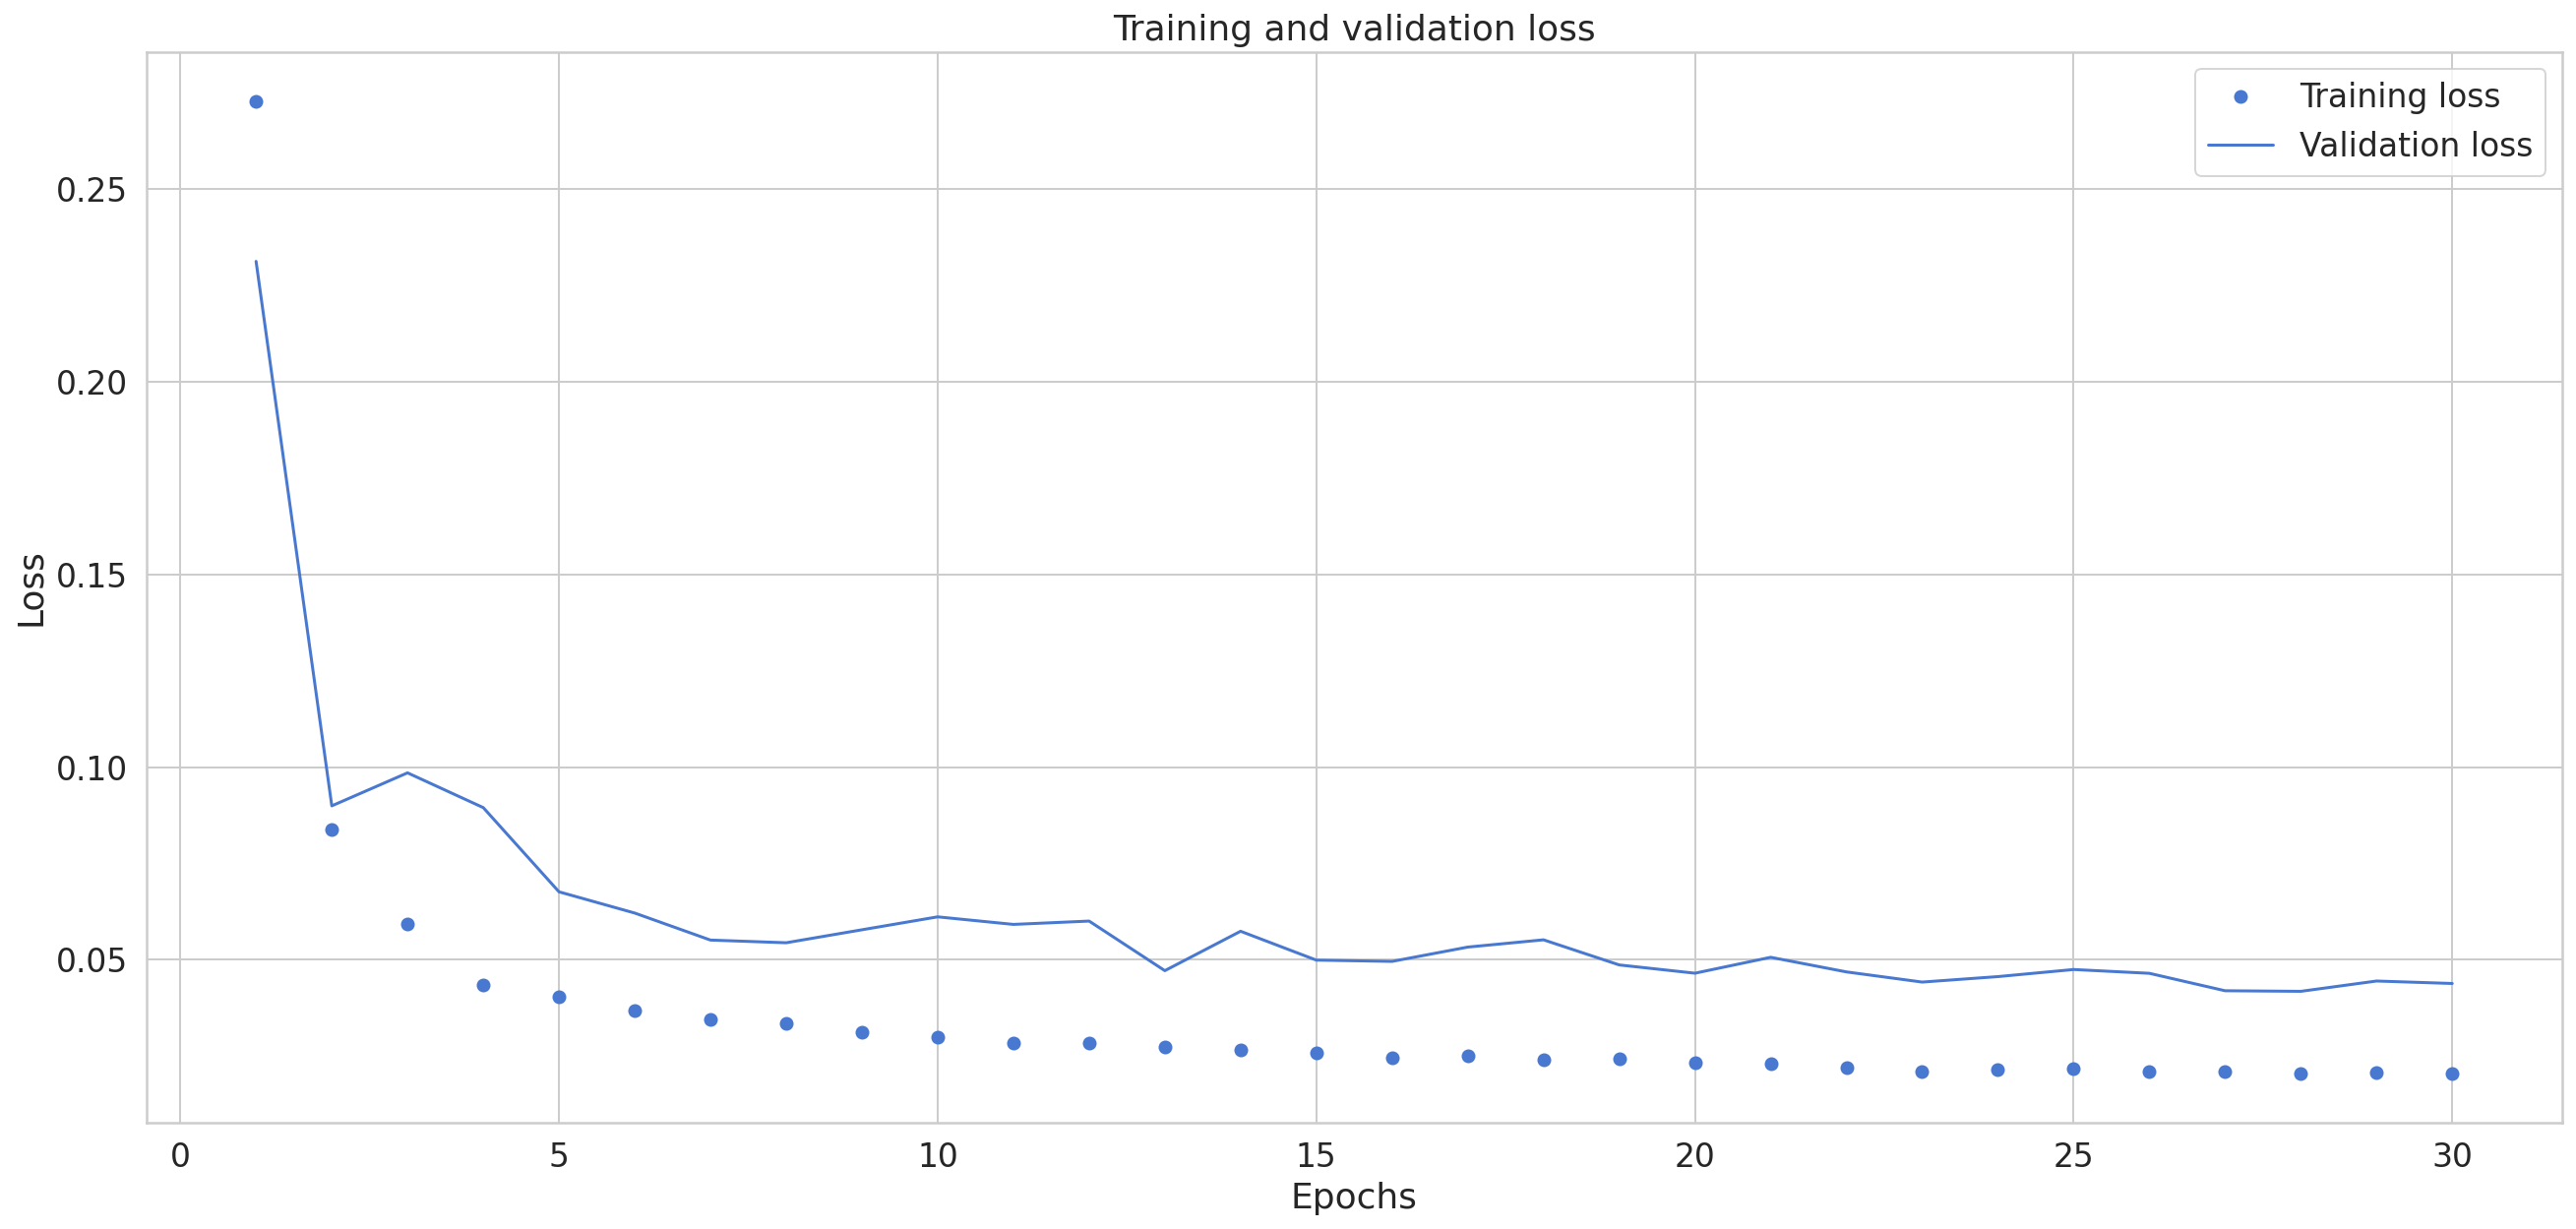

In [17]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
y_pred = model.predict(X_test)

54/54 [==============================] - 1s 11ms/step


In [19]:
train_mse = model.evaluate(X_train, y_train)
test_mse = model.evaluate(X_test, y_test)
 
# Print error
print("Train set MSE = ", train_mse)
print("Test set MSE = ", test_mse)

54/54 [==============================] - 1s 11ms/step - loss: 0.0418
Train set MSE =  0.06062799692153931
Test set MSE =  0.04180408641695976


In [20]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

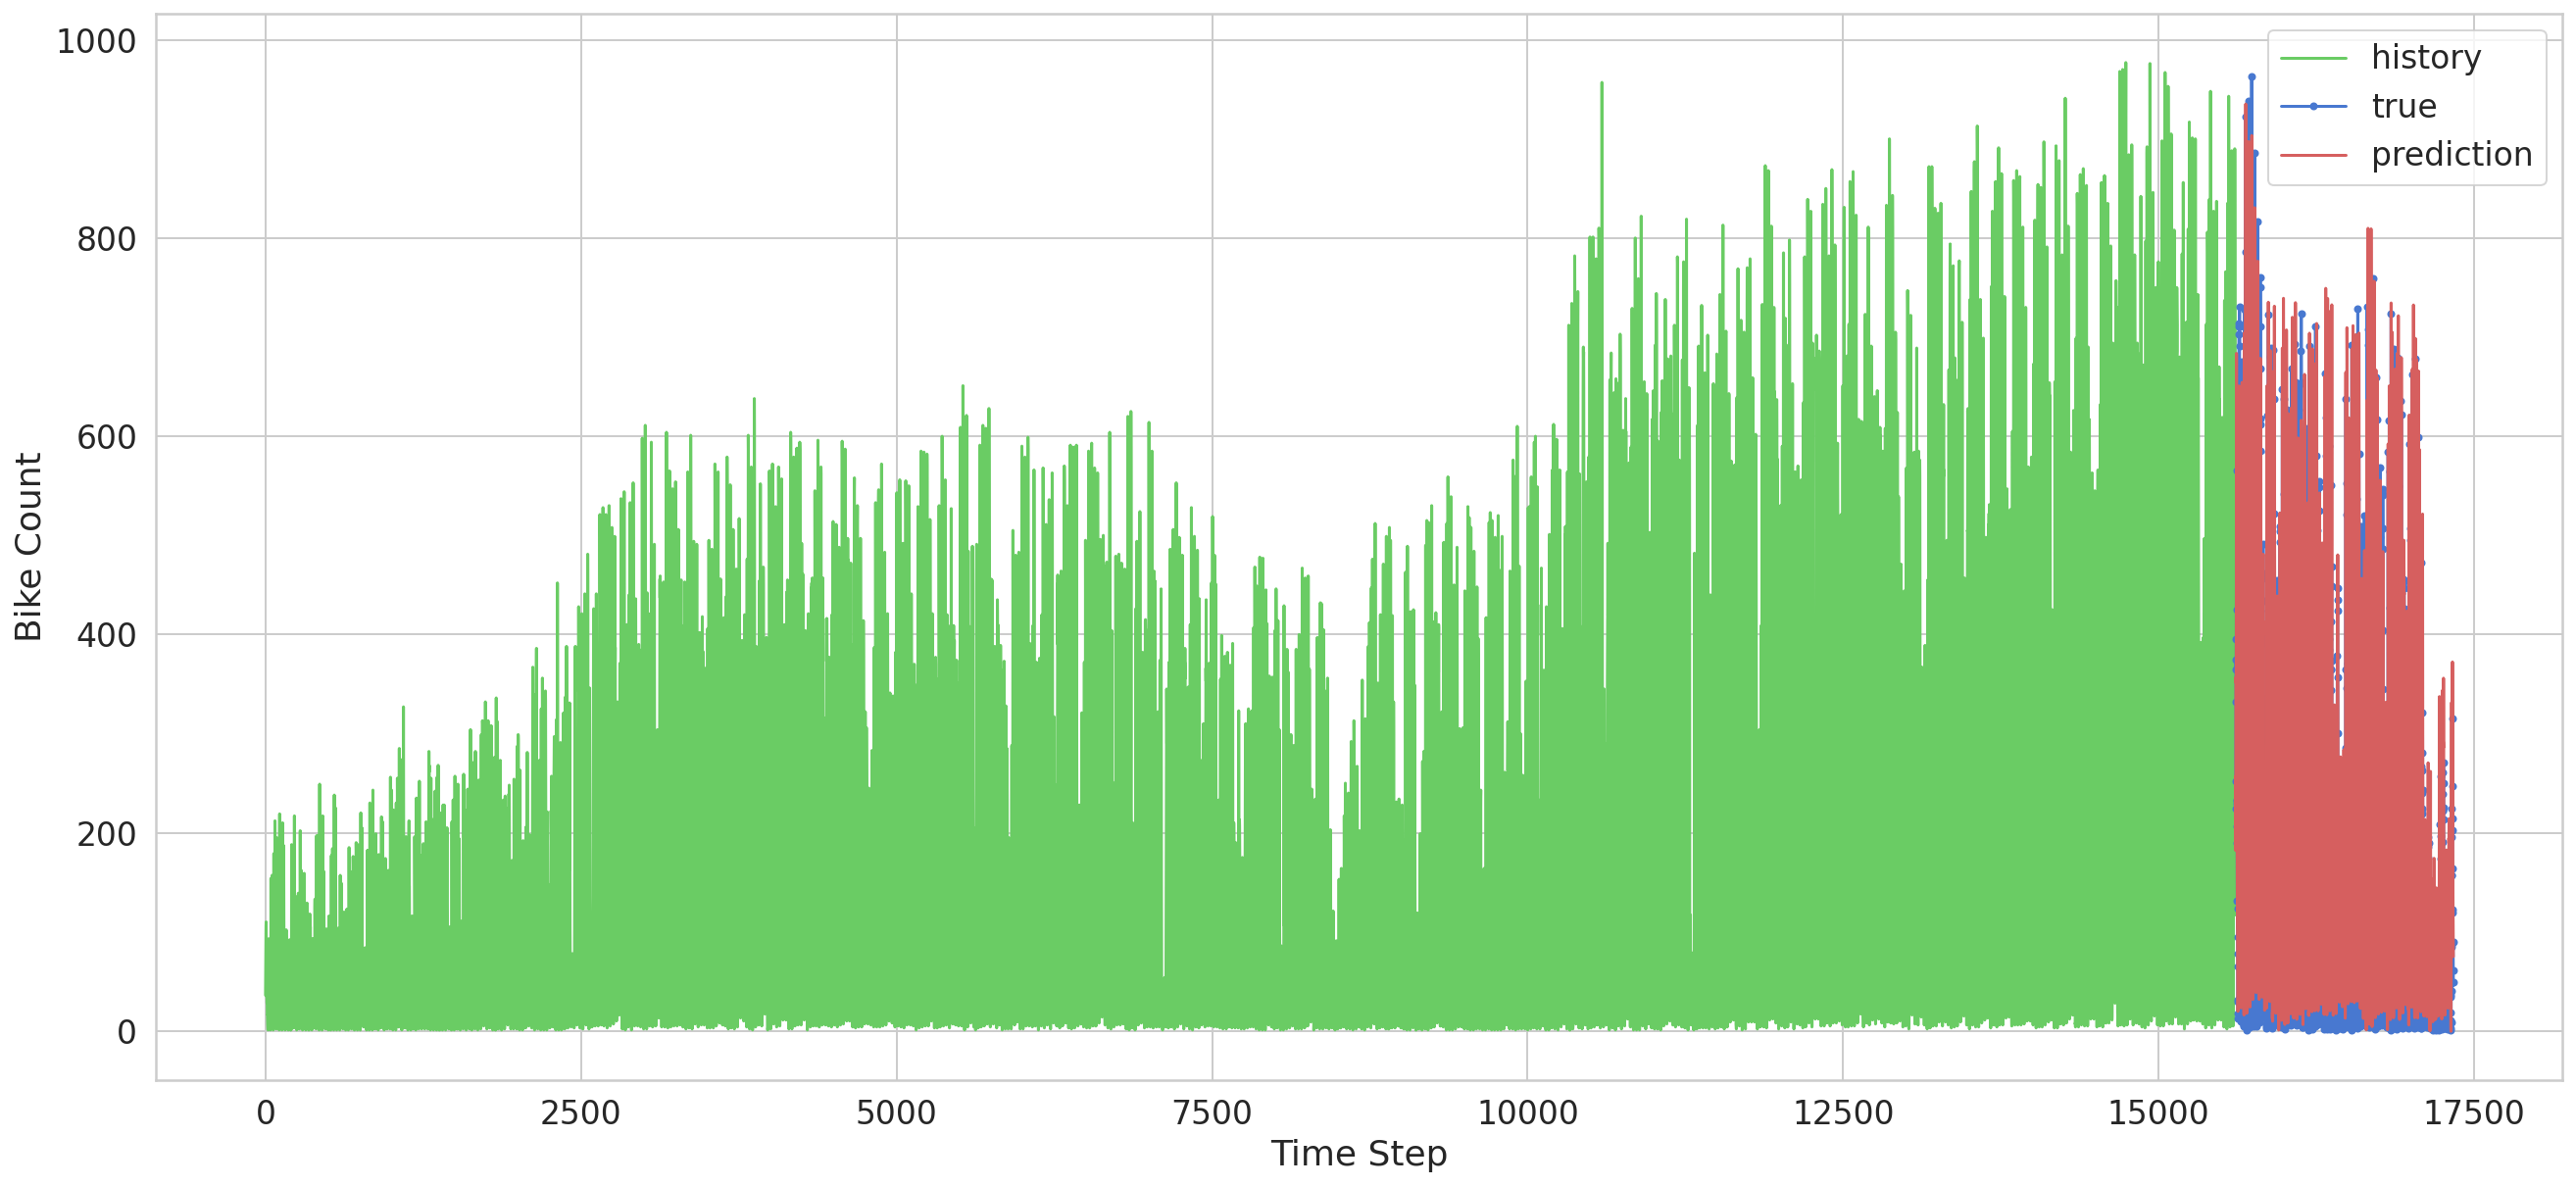

In [21]:

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

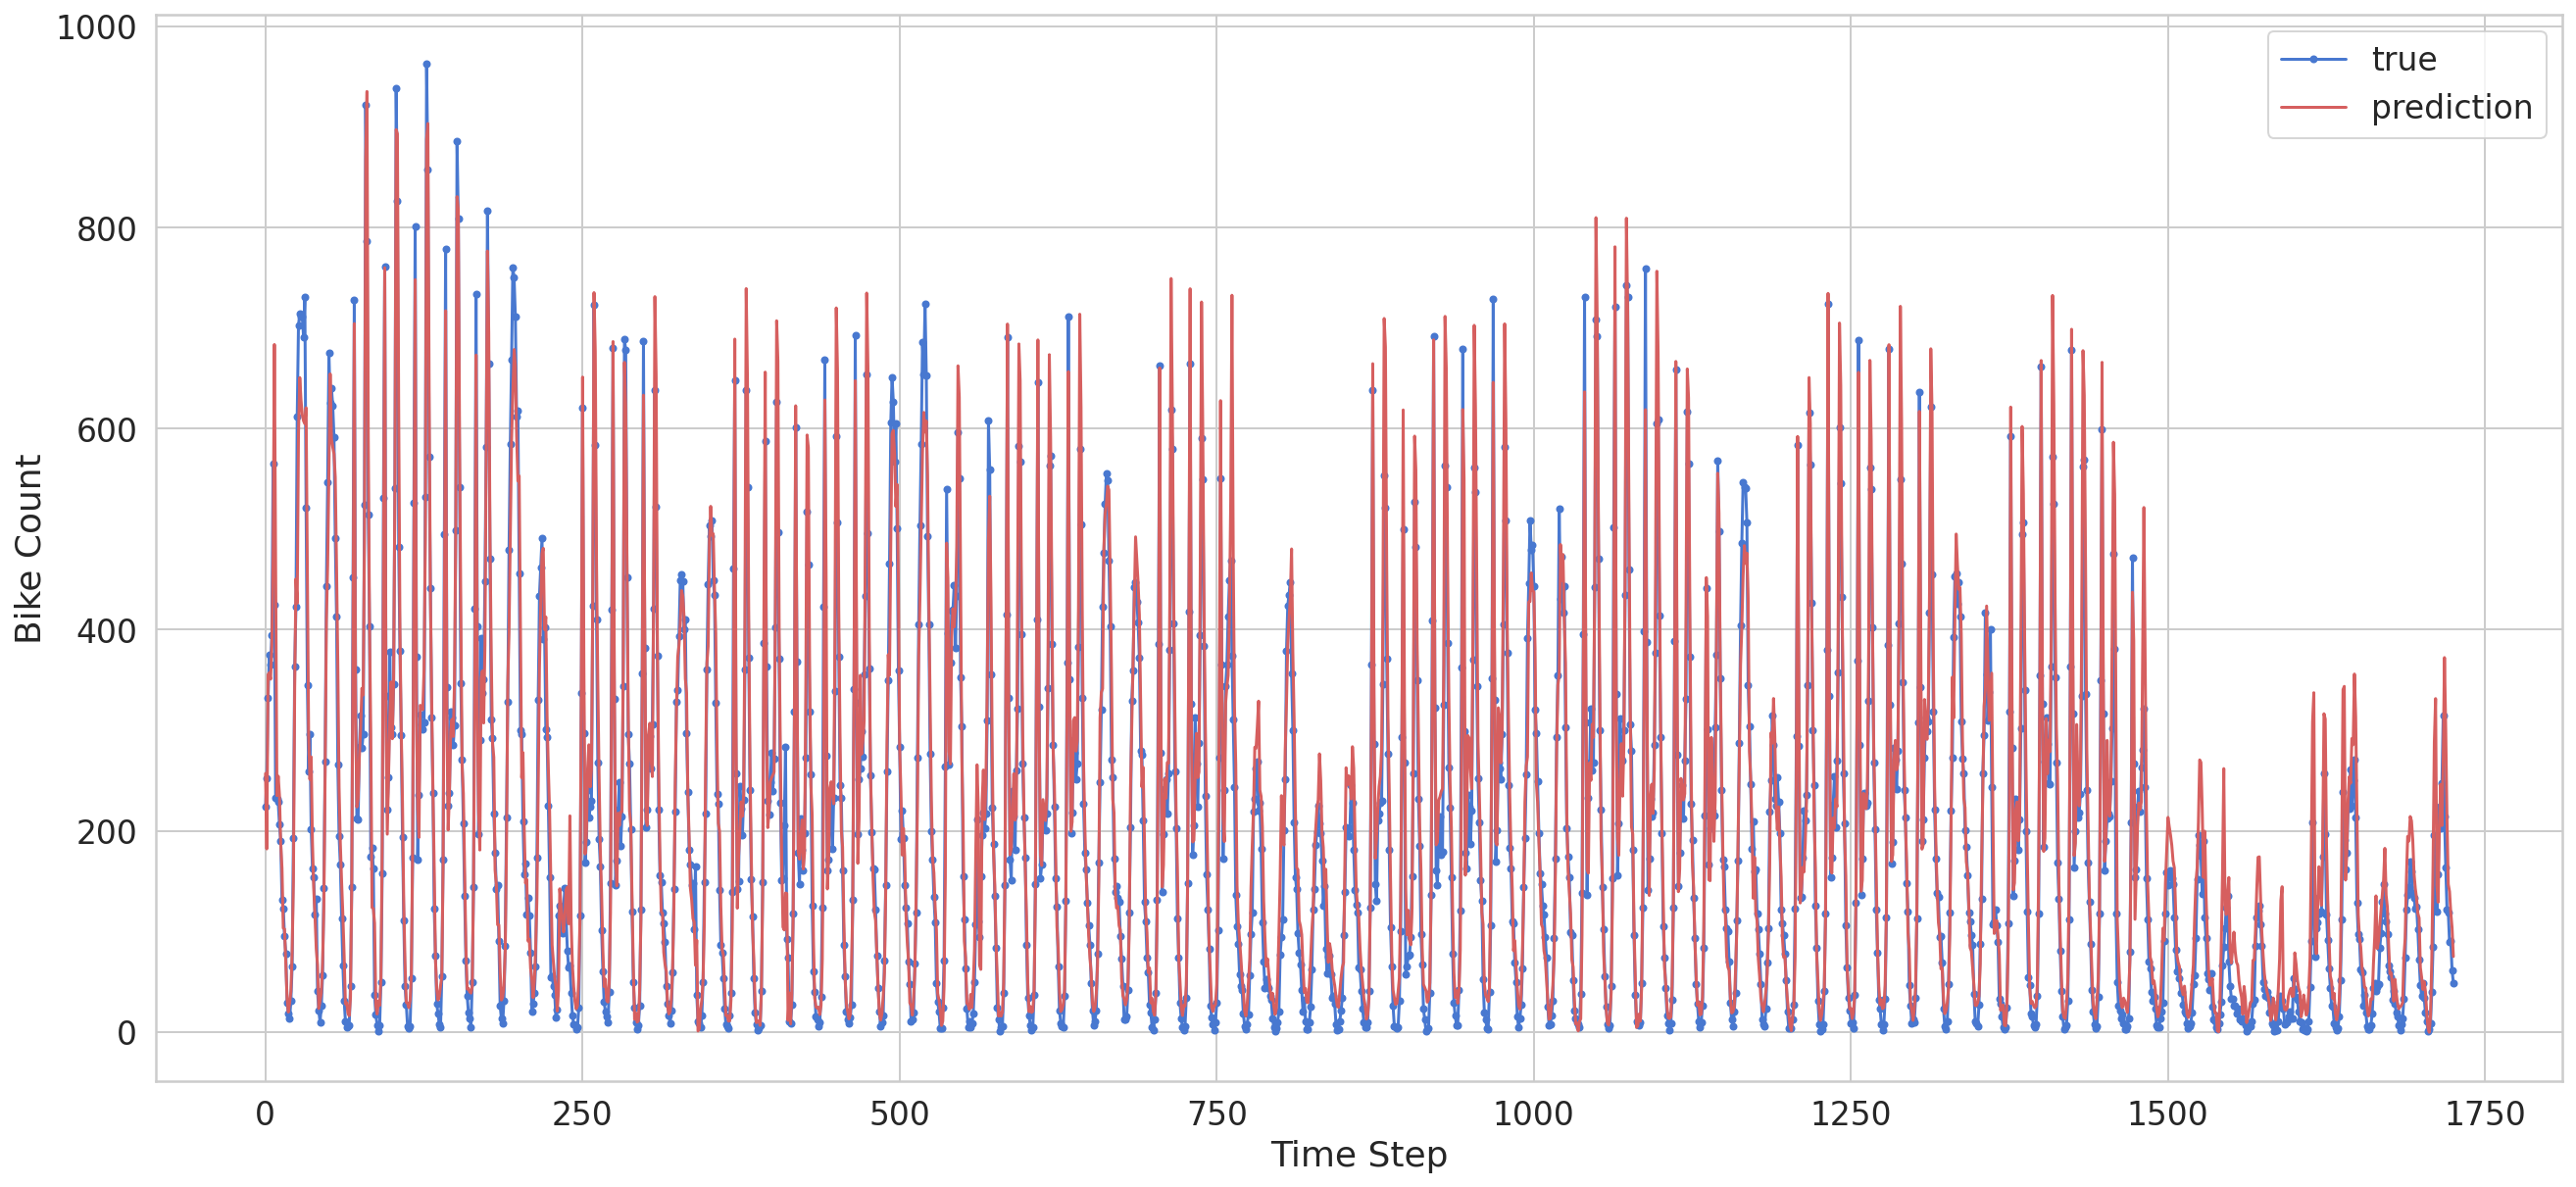

In [22]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [25]:
hidden_units = 2
epochs = 30
time_steps=20
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mse', optimizer='adam')
    return model
 
model_RNN = create_RNN(hidden_units=hidden_units, dense_units=1, input_shape=(X_train.shape[1], X_train.shape[2]), 
                   activation=['tanh', 'tanh'])
model_RNN.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=2)
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context
def create_RNN_with_attention(hidden_units, dense_units, input_shape, activation):
    x=Input(shape=input_shape)
    RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
    attention_layer = attention()(RNN_layer)
    outputs=Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    model=Model(x,outputs)
    model.compile(loss='mse', optimizer='adam')    
    return model    
 

Epoch 1/30
15610/15610 - 35s - loss: 0.3181 - 35s/epoch - 2ms/step
Epoch 2/30
15610/15610 - 30s - loss: 0.1684 - 30s/epoch - 2ms/step
Epoch 3/30
15610/15610 - 33s - loss: 0.1531 - 33s/epoch - 2ms/step
Epoch 4/30
15610/15610 - 30s - loss: 0.1522 - 30s/epoch - 2ms/step
Epoch 5/30
15610/15610 - 30s - loss: 0.1516 - 30s/epoch - 2ms/step
Epoch 6/30
15610/15610 - 31s - loss: 0.1514 - 31s/epoch - 2ms/step
Epoch 7/30
15610/15610 - 30s - loss: 0.1511 - 30s/epoch - 2ms/step
Epoch 8/30
15610/15610 - 33s - loss: 0.1507 - 33s/epoch - 2ms/step
Epoch 9/30
15610/15610 - 32s - loss: 0.1509 - 32s/epoch - 2ms/step
Epoch 10/30
15610/15610 - 30s - loss: 0.1503 - 30s/epoch - 2ms/step
Epoch 11/30
15610/15610 - 31s - loss: 0.1503 - 31s/epoch - 2ms/step
Epoch 12/30
15610/15610 - 30s - loss: 0.1505 - 30s/epoch - 2ms/step
Epoch 13/30
15610/15610 - 30s - loss: 0.1505 - 30s/epoch - 2ms/step
Epoch 14/30
15610/15610 - 30s - loss: 0.1505 - 30s/epoch - 2ms/step
Epoch 15/30
15610/15610 - 30s - loss: 0.1504 - 30s/epoch 

In [26]:
# Create the model with attention, train and evaluate
model_attention = create_RNN_with_attention(hidden_units=hidden_units, dense_units=1, 
                                  input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh')
model_attention.summary()    
 
 
history=model_attention.fit(X_train, y_train,validation_split=0.1, epochs=epochs, batch_size=1, verbose=2)
 
# Evalute model
train_mse_attn = model_attention.evaluate(X_train, y_train)
test_mse_attn = model_attention.evaluate(X_test, y_test)
 
# Print error
print("Train set MSE with attention = ", train_mse_attn)
print("Test set MSE with attention = ", test_mse_attn)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 13)]          0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10, 2)             32        
                                                                 
 attention (attention)       (None, 2)                 12        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 47
Trainable params: 47
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
14049/14049 - 47s - loss: 0.3590 - val_loss: 0.7284 - 47s/epoch - 3ms/step
Epoch 2/30
14049/14049 - 36s - loss: 0.2670 - val_loss: 0.6539 - 36s/epoch - 3ms/step
Epoch 3/30
14049/14049 - 

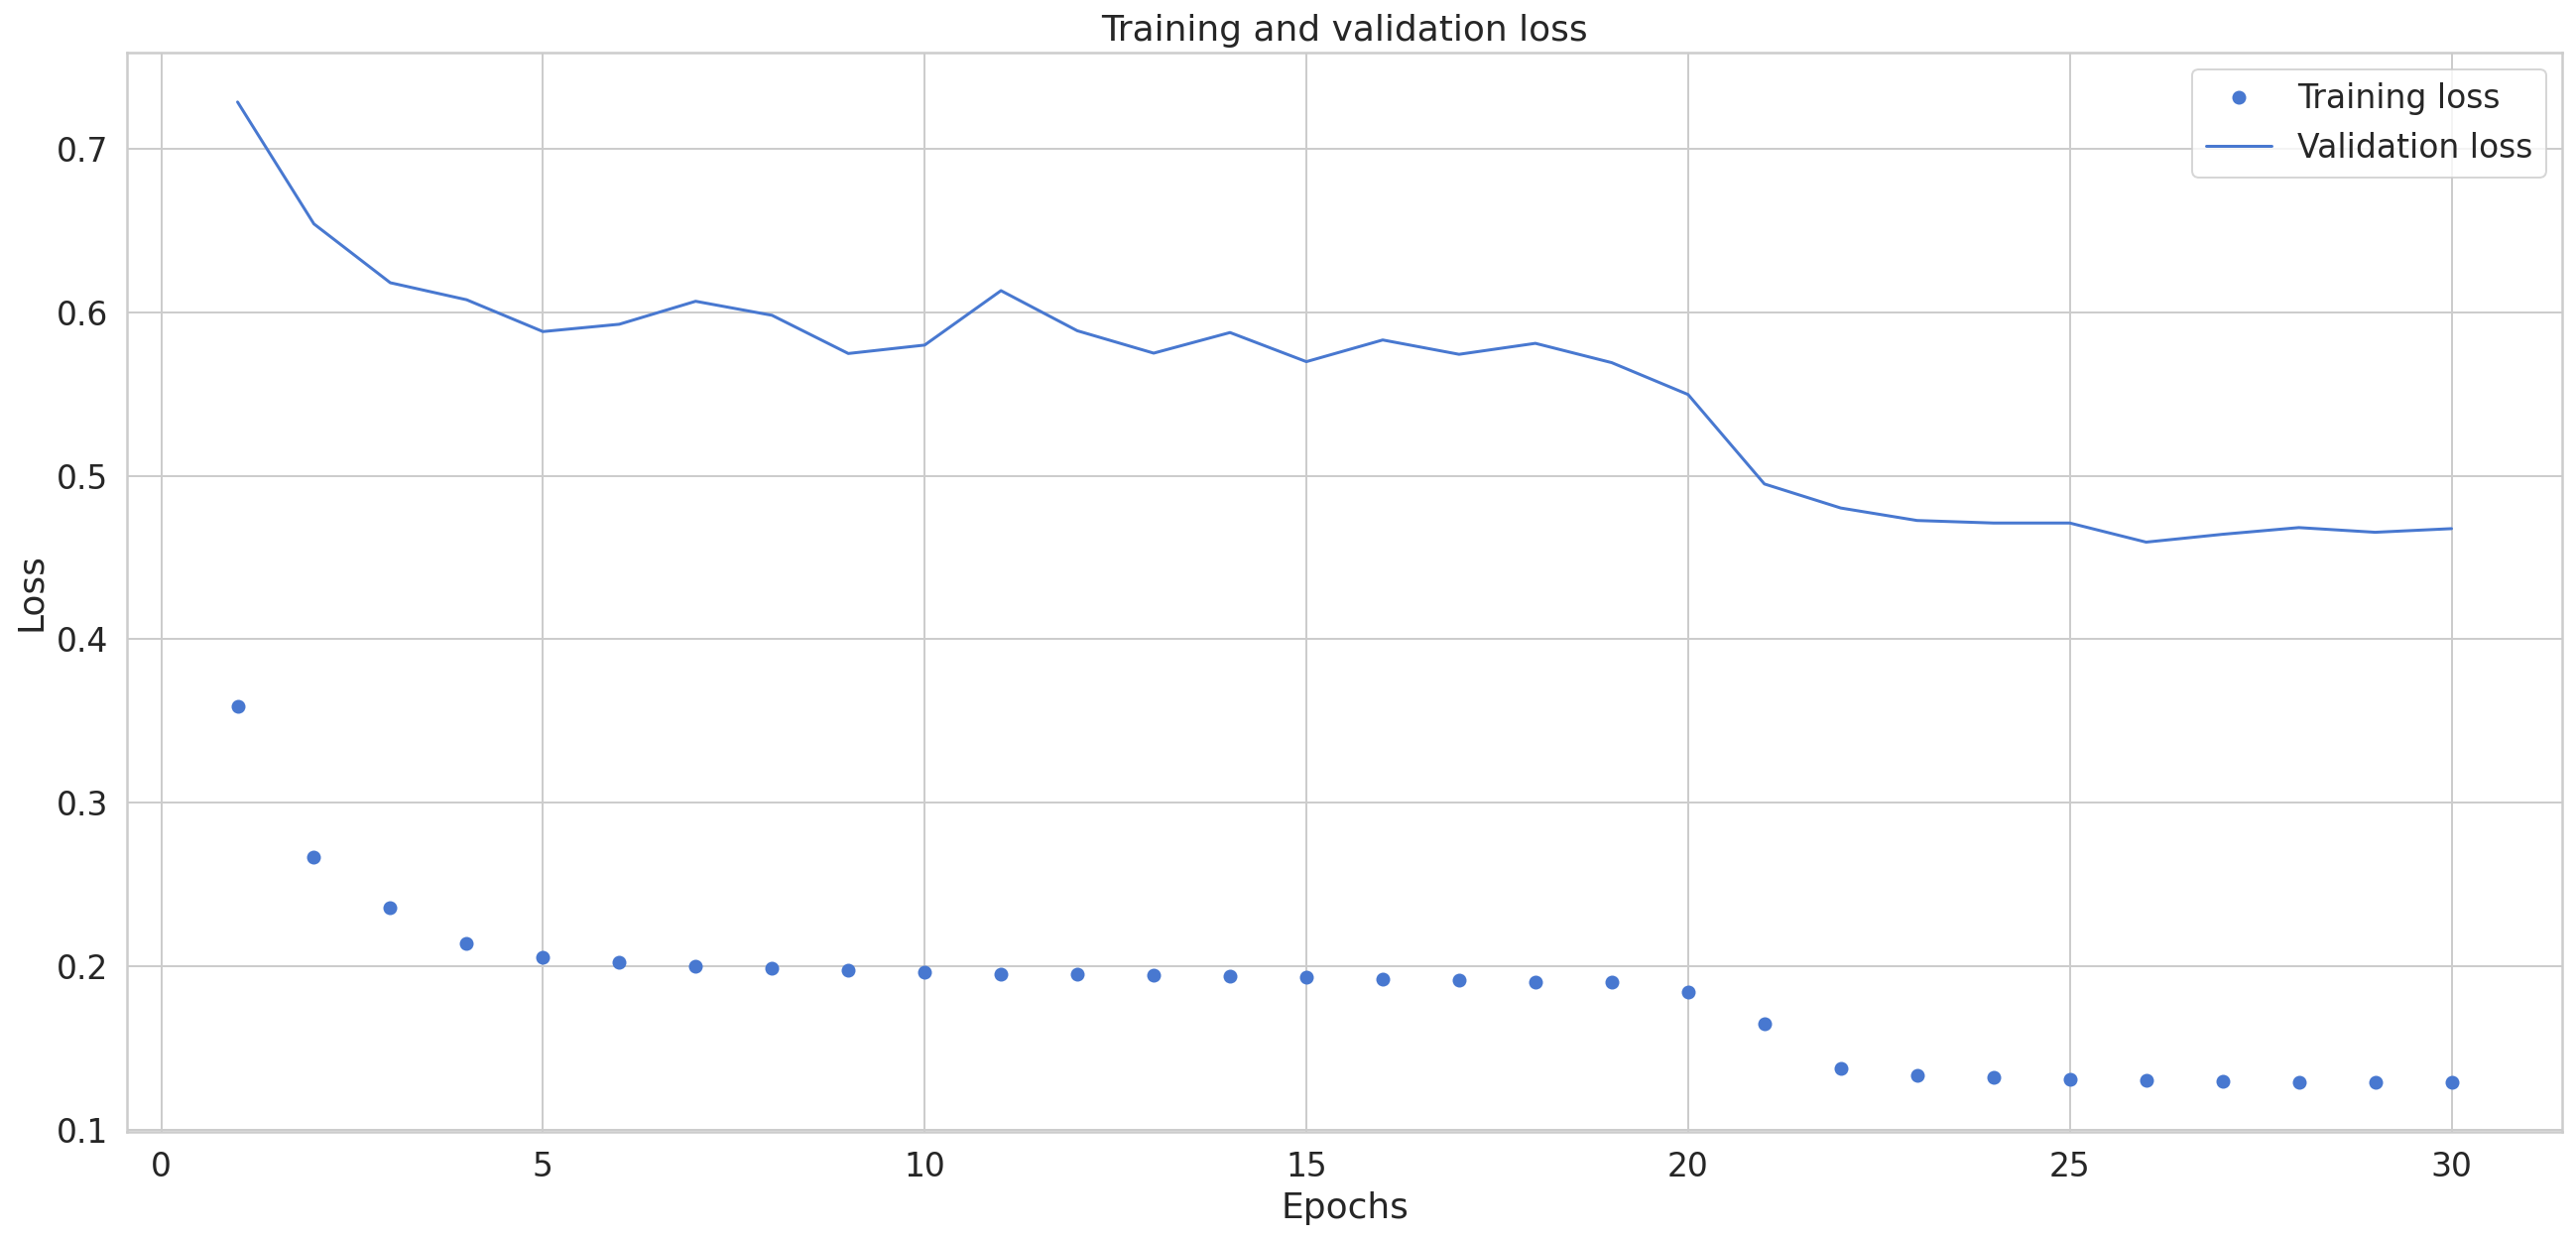

In [27]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()